## Colab Setup

In [5]:
# https://opencv.org/
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
print("accelerator:", accelerator)
!pip install lxml==4.0
!pip install http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

# get terminator
!pip install fastai

# may not be necessary
!apt-get install -y libtiff5-dev

# on some of the VMs PIL is borked
# I am doing this out of abundance of caution
#!CC="cc -mavx2" pip install -U --force-reinstall pillow-simd
!pip install --force-reinstall scipy
!pip install torchvision
!pip install Pillow==4.1.1
!pip install kaggle --upgrade
!apt install p7zip-full

accelerator: cu80


Reading package lists... Done
Building dependency tree       
Reading state information... Done
libtiff5-dev is already the newest version (4.0.8-5ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
  Using cached https://files.pythonhosted.org/packages/a8/0b/f163da98d3a01b3e0ef1cab8dd2123c34aee2bafbb1c5bffa354cc8a1730/scipy-1.1.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/68/1e/116ad560de97694e2d0c1843a7a0075cc9f49e922454d32f49a80eb6f1f2/numpy-1.14.5-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: numpy 1.14.5
    Uninstalling numpy-1.14.5:
      Successfully uninstalled numpy-1.14.5
  Found existing installation: scipy 1.1.0
    Uninstalling scipy-1.1.0:
      Successfully uninstalled scipy-1.1.0
Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.3.12)
Requirement not upgraded as not directly required: urllib3<1.23.0,>=1.15 in /usr/local/lib/python3.6/dist-packages (fr

## Multi-label classification
http://forums.fast.ai/t/wiki-lesson-2/9399

In [6]:
# get me some data
!wget http://files.fast.ai/data/dogscats.zip
!mkdir -p data
!mv dogscats.zip data/dogscats.zip
!unzip -q -o data/dogscats.zip -d data/

--2018-07-16 19:38:18--  http://files.fast.ai/data/dogscats.zip
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 857214334 (818M) [application/zip]
Saving to: ‘dogscats.zip’

dogscats.zip        100%[===================>] 817.50M  67.4MB/s    in 10s     

2018-07-16 19:38:28 (81.3 MB/s) - ‘dogscats.zip’ saved [857214334/857214334]



In [7]:
!mkdir -p ~/.kaggle/
!echo '{"username":"cesaremontresor","key":"d78c0735f7985acc809dcdb1dee29fef"}' > ~/.kaggle/kaggle.json
!cat ~/.kaggle/kaggle.json

!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p ~/data/planet
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p ~/data/planet
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv.zip -p ~/data/planet
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f test_v2_file_mapping.csv.zip -p ~/data/planet

!cd ~/data/planet/; 7z x -so train-jpg.tar.7z | tar xf - 
!cd ~/data/planet/; 7z x -so test-jpg.tar.7z | tar xf - 
!cd ~/data/planet/; unzip -o train_v2.csv.zip
!cd ~/data/planet/; unzip -o test_v2_file_mapping.csv.zip


{"username":"cesaremontresor","key":"d78c0735f7985acc809dcdb1dee29fef"}
train-jpg.tar.7z: Skipping, found more recently modified local copy (use --force to force download)
test-jpg.tar.7z: Skipping, found more recently modified local copy (use --force to force download)
train_v2.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_v2_file_mapping.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  train_v2.csv.zip
  inflating: train_v2.csv            
  inflating: __MACOSX/._train_v2.csv  
Archive:  test_v2_file_mapping.csv.zip
  inflating: test_v2_file_mapping.csv  


In [8]:
!ls
!ls data/
!ls data/planet

data  datalab
dogscats  dogscats.zip	planet
__MACOSX	 test_v2_file_mapping.csv      train-jpg.tar.7z
test-jpg	 test_v2_file_mapping.csv.zip  train_v2.csv
test-jpg.tar.7z  train-jpg		       train_v2.csv.zip


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

In [0]:
PATH = 'data/planet/'

In [12]:
ls {PATH}

__MACOSX/        test_v2_file_mapping.csv      train-jpg.tar.7z
test-jpg/        test_v2_file_mapping.csv.zip  train_v2.csv
test-jpg.tar.7z  train-jpg/                    train_v2.csv.zip


## Multi-label versus single-label classification

In [0]:
from fastai.plots import *

In [0]:
def get_1st(path): return glob(f'{path}/*.*')[0]

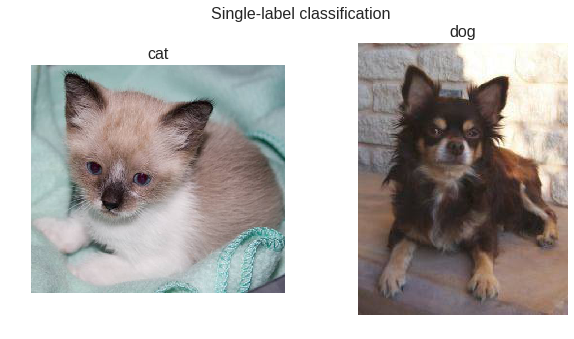

In [15]:
dc_path = "data/dogscats/valid/"
list_paths = [get_1st(f"{dc_path}cats"), get_1st(f"{dc_path}dogs")]
plots_from_files(list_paths, titles=["cat", "dog"], maintitle="Single-label classification")

In single-label classification each sample belongs to one class. In the previous example, each image is either a *dog* or a *cat*.

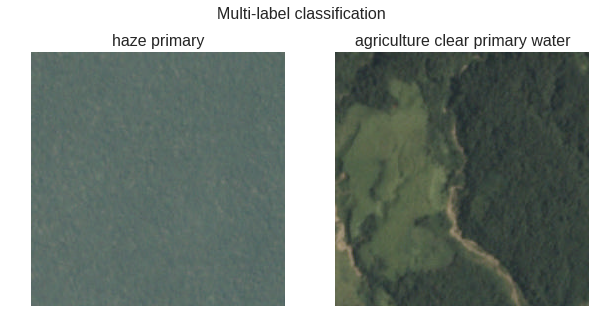

In [16]:
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In multi-label classification each sample can belong to one or more clases. In the previous example, the first images belongs to two clases: *haze* and *primary*. The second image belongs to four clases: *agriculture*, *clear*, *primary* and  *water*.

## Multi-label models for Planet dataset

In [0]:
from fastai.imports import *
from fastai.transforms import *
from fastai.dataset import *
from sklearn.metrics import fbeta_score
import warnings

def f2(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([fbeta_score(targs, (preds>th), 2, average='samples')
                    for th in np.arange(start,end,step)])

def opt_th(preds, targs, start=0.17, end=0.24, step=0.01):
    ths = np.arange(start,end,step)
    idx = np.argmax([fbeta_score(targs, (preds>th), 2, average='samples')
                for th in ths])
    return ths[idx]

def get_data(path, tfms,bs,  n, cv_idx):
    val_idxs = get_cv_idxs(n, cv_idx)
    return ImageClassifierData.from_csv(path, 'train-jpg', f'{path}train_v2.csv', bs, tfms,
                                 suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

def get_data_zoom(f_model, path, sz, bs, n, cv_idx):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return get_data(path, tfms, bs, n, cv_idx)

def get_data_pad(f_model, path, sz, bs, n, cv_idx):
    transforms_pt = [RandomRotateZoom(9, 0.18, 0.1), RandomLighting(0.05, 0.1), RandomDihedral()]
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_pt, pad=sz//12)
    return get_data(path, tfms, bs, n, cv_idx)

In [0]:
metrics=[f2]
f_model = resnet34

In [0]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

In [0]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [0]:
data = get_data(256)

In [0]:
x,y = next(iter(data.val_dl))

In [23]:
y


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

In [24]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

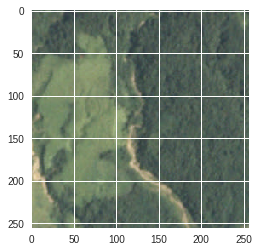

In [25]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [0]:
sz=64

In [0]:
data = get_data(sz)

In [28]:
data = data.resize(int(sz*1.3), 'tmp')

In [29]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /content/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:02<00:00, 38722560.07it/s]


epoch      trn_loss   val_loss   f2         
    0      0.220567   0.256696   0.827096  



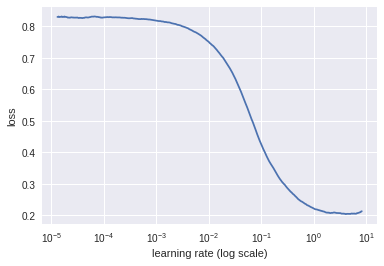

In [30]:
lrf=learn.lr_find()
learn.sched.plot()

In [0]:
lr = 0.2

In [0]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2         
    0      0.149599   0.135385   0.881177  
 36%|███▌      | 181/506 [00:22<00:40,  8.07it/s, loss=0.146]

    1      0.145851   0.129513   0.887704  
 71%|███████   | 360/506 [00:44<00:18,  8.07it/s, loss=0.138]

    2      0.137272   0.127898   0.887766  
 52%|█████▏    | 264/506 [00:32<00:29,  8.12it/s, loss=0.141]

In [0]:
lrs = np.array([lr/9,lr/3,lr])

In [0]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

In [0]:
learn.save(f'{sz}')

In [0]:
learn.sched.plot_loss()

In [0]:
sz=128

In [0]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [0]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

In [0]:
sz=256

In [0]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [0]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

In [0]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [0]:
f2(preds,y)

### End